In [97]:
""" RNN dam flow prediction: stacked RNN """

# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten,SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [98]:
rain_data = pd.read_csv('rain_day.csv', encoding='utf-8')
dam_data = pd.read_csv('dam_edit.csv', encoding='utf-8')

In [99]:
data = []

In [100]:
dam_data = dam_data.drop('Unnamed: 0', axis = 1)

In [101]:
data = pd.merge( dam_data,rain_data, on='date', how='inner')

In [102]:
data = data.fillna(0)

In [103]:
print(data)

             date  dam_t-1    90  100  101  211  212
0      1974-01-01    0.000   0.0  0.0  0.0  0.0  0.0
1      1974-01-02   10.000   0.0  0.0  0.0  0.0  0.0
2      1974-01-03    9.000   0.0  0.0  0.0  0.0  0.0
3      1974-01-04    4.800   0.0  0.0  0.0  0.0  0.0
4      1974-01-05    6.100   0.0  0.0  0.0  0.0  0.0
...           ...      ...   ...  ...  ...  ...  ...
18257  2023-12-27   30.518   0.0  0.0  0.0  0.0  0.0
18258  2023-12-28   25.873   0.0  0.0  0.0  0.0  0.0
18259  2023-12-29   21.186   0.0  0.0  0.0  0.0  0.0
18260  2023-12-30   20.887   0.7  2.3  9.9  6.8  8.5
18261  2023-12-31   29.183  26.8  6.0  5.3  3.1  4.9

[18262 rows x 7 columns]


In [104]:
print(dam_data)

             date  dam_t-1
0      1974-01-01    0.000
1      1974-01-02   10.000
2      1974-01-03    9.000
3      1974-01-04    4.800
4      1974-01-05    6.100
...           ...      ...
18257  2023-12-27   30.518
18258  2023-12-28   25.873
18259  2023-12-29   21.186
18260  2023-12-30   20.887
18261  2023-12-31   29.183

[18262 rows x 2 columns]


In [105]:
dam = dam_data.drop('date', axis= 1)

In [106]:
print(rain_data)

             date    90  100  101  211  212
0      1974-01-01   0.0  0.0  0.0  0.0  0.0
1      1974-01-02   0.0  0.0  0.0  0.0  0.0
2      1974-01-03   0.0  0.0  0.0  0.0  0.0
3      1974-01-04   0.0  0.0  0.0  0.0  0.0
4      1974-01-05   0.0  0.0  0.0  0.0  0.0
...           ...   ...  ...  ...  ...  ...
18257  2023-12-27   0.0  0.0  0.0  0.0  0.0
18258  2023-12-28   0.0  0.0  0.0  0.0  0.0
18259  2023-12-29   0.0  0.0  0.0  0.0  0.0
18260  2023-12-30   0.7  2.3  9.9  6.8  8.5
18261  2023-12-31  26.8  6.0  5.3  3.1  4.9

[18262 rows x 6 columns]


In [107]:
data = data[9496:]

In [108]:
data

,date,dam_t-1,90,100,101,211,212
9496,2000-01-01,13.000,1.2,1.0,0.0,0.0,0.0
9497,2000-01-02,15.900,1.1,3.1,8.9,7.0,9.0
9498,2000-01-03,20.400,0.0,0.0,0.0,0.0,0.0
9499,2000-01-04,16.000,0.0,0.0,0.0,0.0,0.0
9500,2000-01-05,13.700,10.4,9.1,12.0,5.8,12.0
...,...,...,...,...,...,...,...
18257,2023-12-27,30.518,0.0,0.0,0.0,0.0,0.0
18258,2023-12-28,25.873,0.0,0.0,0.0,0.0,0.0
18259,2023-12-29,21.186,0.0,0.0,0.0,0.0,0.0
18260,2023-12-30,20.887,0.7,2.3,9.9,6.8,8.5


In [109]:
# save original 'Open' prices for later
original_dam = data['dam_t-1'].values

In [110]:
# separate dates for future plotting
dates = pd.to_datetime(data['date'])

In [111]:
print(data)

             date  dam_t-1    90  100   101  211   212
9496   2000-01-01   13.000   1.2  1.0   0.0  0.0   0.0
9497   2000-01-02   15.900   1.1  3.1   8.9  7.0   9.0
9498   2000-01-03   20.400   0.0  0.0   0.0  0.0   0.0
9499   2000-01-04   16.000   0.0  0.0   0.0  0.0   0.0
9500   2000-01-05   13.700  10.4  9.1  12.0  5.8  12.0
...           ...      ...   ...  ...   ...  ...   ...
18257  2023-12-27   30.518   0.0  0.0   0.0  0.0   0.0
18258  2023-12-28   25.873   0.0  0.0   0.0  0.0   0.0
18259  2023-12-29   21.186   0.0  0.0   0.0  0.0   0.0
18260  2023-12-30   20.887   0.7  2.3   9.9  6.8   8.5
18261  2023-12-31   29.183  26.8  6.0   5.3  3.1   4.9

[8766 rows x 7 columns]


In [112]:
# variables for training
cols = list(data)[1:7]

In [113]:
print(cols)

['dam_t-1', '90', '100', '101', '211', '212']


In [114]:
# new dataframe with only training data - 5 columns
data = data[cols].astype(float)

In [115]:
# normalize the dataset
scaler = MinMaxScaler(feature_range = (0,1))
dam_data_scaled = scaler.fit_transform(data)


In [116]:
scaler_dam = MinMaxScaler(feature_range=(0,1))
dam_scaled = scaler_dam.fit_transform(dam)

In [117]:
print(dam_data_scaled)

[[0.00308923 0.00325468 0.00140351 0.         0.         0.        ]
 [0.00377837 0.00298346 0.00435088 0.03390476 0.02777778 0.03522505]
 [0.00484772 0.         0.         0.         0.         0.        ]
 ...
 [0.0050345  0.         0.         0.         0.         0.        ]
 [0.00496344 0.00189856 0.00322807 0.03771429 0.02698413 0.0332681 ]
 [0.00693485 0.07268782 0.00842105 0.02019048 0.01230159 0.01917808]]


In [118]:
# split to train data and test data
n_train = int(0.9*dam_data_scaled.shape[0])
train_data_scaled = dam_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = dam_data_scaled[n_train:]
test_dates = dates[n_train:]
print(test_dates.head(5))

17385   2021-08-07
17386   2021-08-08
17387   2021-08-09
17388   2021-08-10
17389   2021-08-11
Name: date, dtype: datetime64[ns]


In [119]:
print(train_data_scaled)

[[0.00308923 0.00325468 0.00140351 0.         0.         0.        ]
 [0.00377837 0.00298346 0.00435088 0.03390476 0.02777778 0.03522505]
 [0.00484772 0.         0.         0.         0.         0.        ]
 ...
 [0.00855836 0.         0.         0.         0.         0.        ]
 [0.00594012 0.         0.         0.         0.         0.        ]
 [0.00463028 0.04393816 0.02049123 0.00190476 0.03888889 0.0183953 ]]


In [120]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 48   # sequence length = past days for future prediction.
input_dim = 6  # input_dimension = ['dam', '90', '100', '101', '211', '212']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

print(trainX[0])
print(trainY[0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

[[0.00308923 0.00325468 0.00140351 0.         0.         0.        ]
 [0.00377837 0.00298346 0.00435088 0.03390476 0.02777778 0.03522505]
 [0.00484772 0.         0.         0.         0.         0.        ]
 [0.00380213 0.         0.         0.         0.         0.        ]
 [0.00325557 0.02820721 0.01277193 0.04571429 0.02301587 0.04696673]
 [0.00520417 0.01627339 0.01136842 0.04609524 0.04325397 0.06457926]
 [0.00727157 0.         0.0002807  0.         0.         0.        ]
 [0.0025902  0.         0.00014035 0.0007619  0.         0.00039139]
 [0.00563191 0.         0.         0.         0.         0.        ]
 [0.00365955 0.         0.         0.00038095 0.00039683 0.        ]
 [0.00441998 0.00054245 0.         0.         0.         0.        ]
 [0.00437245 0.08543531 0.01080702 0.02057143 0.00396825 0.01174168]
 [0.00489524 0.0070518  0.00463158 0.0152381  0.01468254 0.01565558]
 [0.00320805 0.         0.         0.         0.         0.        ]
 [0.00306547 0.         0.        

In [121]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(7841, 48, 6) (7841, 1)
(829, 48, 6) (829, 1)


In [122]:
print(data)

       dam_t-1    90  100   101  211   212
9496    13.000   1.2  1.0   0.0  0.0   0.0
9497    15.900   1.1  3.1   8.9  7.0   9.0
9498    20.400   0.0  0.0   0.0  0.0   0.0
9499    16.000   0.0  0.0   0.0  0.0   0.0
9500    13.700  10.4  9.1  12.0  5.8  12.0
...        ...   ...  ...   ...  ...   ...
18257   30.518   0.0  0.0   0.0  0.0   0.0
18258   25.873   0.0  0.0   0.0  0.0   0.0
18259   21.186   0.0  0.0   0.0  0.0   0.0
18260   20.887   0.7  2.3   9.9  6.8   8.5
18261   29.183  26.8  6.0   5.3  3.1   4.9

[8766 rows x 6 columns]


In [123]:
# RNN model
model = Sequential()
# model.add(Flatten(input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(SimpleRNN(64, activation ='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(32))
model.add(Dense(trainY.shape[1]))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 64)                4544      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6657 (26.00 KB)
Trainable params: 6657 (26.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

No weights found, training model from scratch
Epoch 1/30
221/221 [==============================] - 2s 5ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 2/30
221/221 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 8.7496e-04
Epoch 3/30
221/221 [==============================] - 1s 5ms/step - loss: 5.7849e-04 - val_loss: 6.1650e-04
Epoch 4/30
221/221 [==============================] - 1s 5ms/step - loss: 4.7783e-04 - val_loss: 7.4237e-04
Epoch 5/30
221/221 [==============================] - 1s 4ms/step - loss: 5.8567e-04 - val_loss: 0.0011
Epoch 6/30
221/221 [==============================] - 1s 4ms/step - loss: 4.7726e-04 - val_loss: 9.8239e-04
Epoch 7/30
221/221 [==============================] - 1s 5ms/step - loss: 3.8947e-04 - val_loss: 8.1005e-04
Epoch 8/30
221/221 [==============================] - 1s 5ms/step - loss: 3.2249e-04 - val_loss: 6.9558e-04
Epoch 9/30
221/221 [==============================] - 1s 4ms/step - loss: 4.0091e-04 - val_loss: 0.0010
Ep

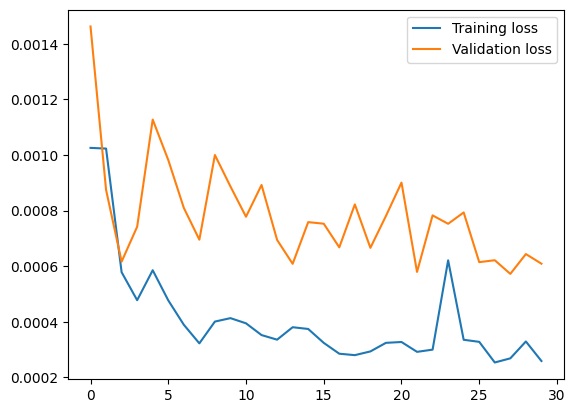

In [125]:
# Try to load weights
try:
    model.load_weights('48dam_rnn2_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('48dam_rnn2_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

26/26 [==============================] - 0s 2ms/step
(829,)


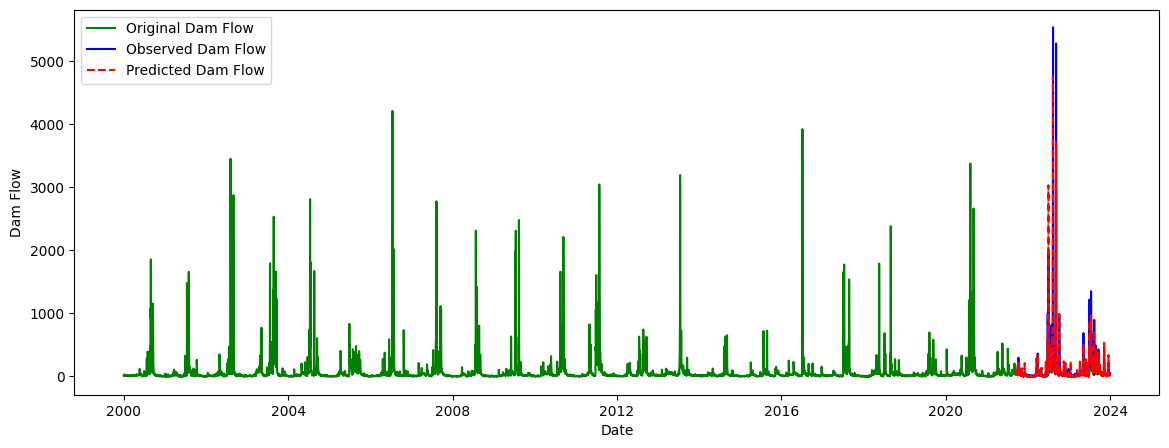

In [126]:
prediction = model.predict(testX)

y_pred = scaler_dam.inverse_transform(prediction)[:,0]

testY_original = scaler_dam.inverse_transform(testY)[:,0]
print(testY_original.shape)

# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_dam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Observed Dam Flow')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Dam Flow')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
# plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

In [127]:
testDates = []
for day in test_dates[24:]:
  testDates.append(day.strftime("%Y-%m-%d"))

testDates = pd.DataFrame(testDates)
pred_y = pd.DataFrame(y_pred)
original_y = pd.DataFrame(testY_original)

rnn_include_dam = pd.concat([testDates, original_y, pred_y], axis = 1)
print(rnn_include_dam)

rnn_include_dam = pd.DataFrame(rnn_include_dam)
rnn_include_dam.to_csv("./data/rnn_include_dam.csv")

              0          0          0
0    2021-08-31  69.171331  94.579315
1    2021-09-01  48.227760  35.177967
2    2021-09-02  48.247118  37.379601
3    2021-09-03  48.234799  25.925943
4    2021-09-04  37.132120  17.830683
..          ...        ...        ...
848  2023-12-27        NaN        NaN
849  2023-12-28        NaN        NaN
850  2023-12-29        NaN        NaN
851  2023-12-30        NaN        NaN
852  2023-12-31        NaN        NaN

[853 rows x 3 columns]


In [128]:
testX_last = []

for x in testX:
  testX_last.append(x[-1])

print(testX_last[0])

testX_last = scaler.inverse_transform(testX_last)
testX_last = pd.DataFrame(testX_last)

rnn_include_x = pd.concat([testDates, testX_last, original_y, pred_y], axis = 1)
rnn_include_x.to_csv("./data/rnn_include_x.csv")

print(rnn_include_x)

[0.01074791 0.         0.         0.         0.         0.        ]
              0       0     1    2    3    4    5          0          0
0    2021-08-31  45.229   0.0  0.0  0.0  0.0  0.0  69.171331  94.579315
1    2021-09-01  39.306  11.4  7.2  0.0  0.2  0.0  48.227760  35.177967
2    2021-09-02  27.405   9.4  6.8  0.0  0.0  0.0  48.247118  37.379601
3    2021-09-03  27.416   0.0  1.1  0.0  0.0  0.0  48.234799  25.925943
4    2021-09-04  27.409   0.0  0.5  0.0  0.0  0.0  37.132120  17.830683
..          ...     ...   ...  ...  ...  ...  ...        ...        ...
848  2023-12-27     NaN   NaN  NaN  NaN  NaN  NaN        NaN        NaN
849  2023-12-28     NaN   NaN  NaN  NaN  NaN  NaN        NaN        NaN
850  2023-12-29     NaN   NaN  NaN  NaN  NaN  NaN        NaN        NaN
851  2023-12-30     NaN   NaN  NaN  NaN  NaN  NaN        NaN        NaN
852  2023-12-31     NaN   NaN  NaN  NaN  NaN  NaN        NaN        NaN

[853 rows x 9 columns]


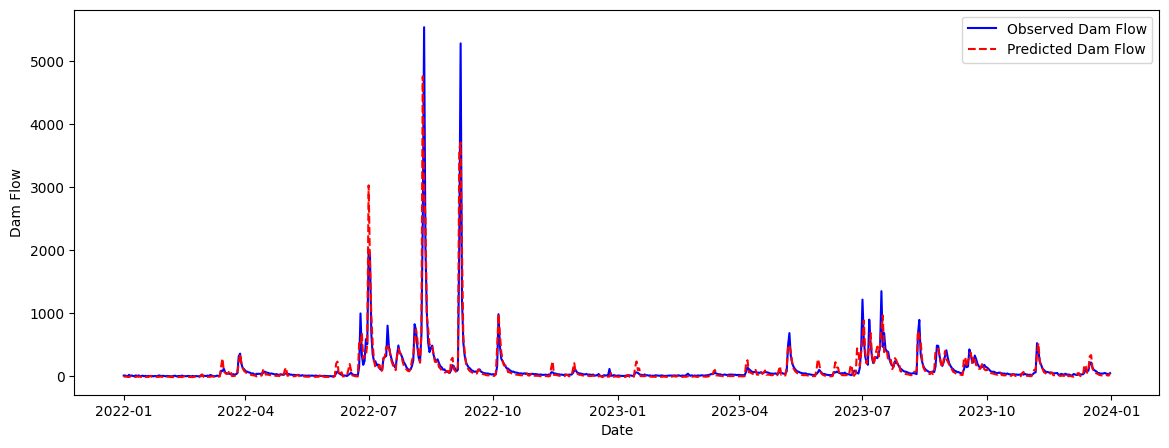

In [129]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 365*2
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Observed Dam Flow')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
# plt.title('Zoomed In Actual vs Predicted Dam Flow')
plt.legend()
plt.show()

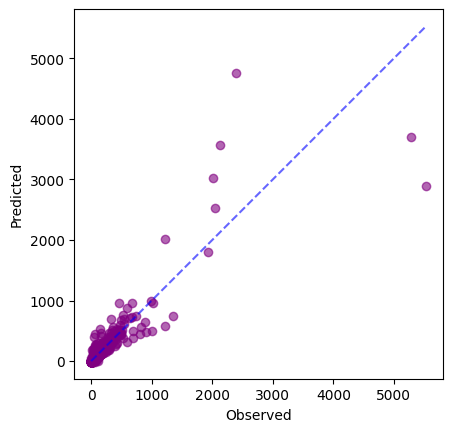

In [130]:
# 일대일 그래프
x = np.arange(0,max(max(testY_original), max(y_pred)))
y = x
plt.scatter(testY_original[:], y_pred[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue',linestyle = '--', alpha = 0.6, label = 'y = x')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.gca().set_aspect("equal")

# plt.legend()
plt.show()

In [131]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

RMSE : 168.22


In [132]:
# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

NSE : 0.756028


In [133]:
# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

PBIAS : 3.924540


In [134]:
#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

R Square : 0.769311


In [135]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

RMSE : 168.22
NSE : 0.756028
PBIAS : 3.924540
R Square : 0.769311
